# Model Building for NYC Collision dataset on AI Platform

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import pandas_profiling as pdp

import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
from io import BytesIO
import datetime
from datetime import timedelta
import tensorflow as tf
import sys
import datalab.storage as storage

In [3]:
BUCKET='nyc_collision_model'
PROJECT='summerai'
REGION='us-central1'

os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [4]:
df = pd.read_csv('data/accidents_with_prediction.csv')

In [5]:
def extract_ddy(date):
    dd = date.split(' ')
    year_month = dd[0][:7]
    year_month_day = dd[0]
    year = int(year_month[:4])
    month = int(year_month[5:7])
    hour = int(dd[1][:2])
    return year_month_day, year, month, hour

In [6]:
def divide_data(data):
    data_np = data.values
    train = []
    for i in range(90, len(data_np)):
        train.append(data_np[i-90:i])
        
    list_zero = train[0]
    df = pd.DataFrame(list_zero).T
    
    for i in range(1, len(train)):
        a = train[i]
        b = pd.DataFrame(a).T
        b.index = [i]
        df = pd.concat((df, b), axis = 0)
        
    ind = int(0.8*len(df))
    train = df[:ind]
    eval_ = df[ind:]
    test = eval_.iloc[-1]
    test = test[30:]
    
    
    last_date = data[-30:-29]
    last_date = last_date.index
    
    dates = []
    for i in range(0, 60):
        temp = last_date + timedelta(days = 1)
        dates.append(last_date)
        last_date = temp
    dates = pd.DataFrame(dates)
    
    return train, eval_, test, dates

In [8]:
def generic_function_to_test_train_data(df1, name):
    df1 = df1.reset_index().iloc[:, 1:]
    
    ym, y, m, h = [], [], [], []

    for i in range(len(df1)):
        a, b, c, d= extract_ddy(df1.timestamp[i])
        ym.append(a)
        y.append(b)
        m.append(c)
        h.append(d)

    df1['date'] = ym
    df1['year'] = y
    df1['month'] = m
    df1['hour'] = h
    
    df1.set_index(df1['date'],inplace=True)
    df2 = pd.DataFrame(df1['date'].value_counts())
    df2.columns = ['count']
    df2.index = pd.to_datetime(df2.index)
    daily = df2['count'].resample('D').sum()
    
    train, eval_, test, dates = divide_data(daily)
    
    test = test.tolist()
    train.to_csv("data/"+ name +"_train.csv", index=False, header=False)
    eval_.to_csv("data/"+ name +"_eval.csv", index=False, header=False)
    storage.Bucket(BUCKET).item('data/'+ name +'_train.csv').write_to(train.to_csv(index=False, header=False),'text/csv')
    storage.Bucket(BUCKET).item('data/'+ name +'_eval.csv').write_to(eval_.to_csv(index=False, header=False),'text/csv')
    return daily, test, dates

**Dataset divided into train and test and saved in the Bucket.**

In [9]:
df1, test1, dates1 = generic_function_to_test_train_data(df[df['borough'] == 'MANHATTAN'], 'manhattan')

In [10]:
df2, test2, dates2 = generic_function_to_test_train_data(df[df['borough'] == 'BROOKLYN'], 'brooklyn')
df3, test3, dates3 = generic_function_to_test_train_data(df[df['borough'] == 'QUEENS'], 'queens')
df4, test4, dates4 = generic_function_to_test_train_data(df[df['borough'] == 'BRONX'], 'bronx')
df5, test5, dates5 = generic_function_to_test_train_data(df[df['borough'] == 'STATEN ISLAND'], 'statenisland')

## Now it is time to make this models run on the Platform, Do some Hyperparameter tuning and try deploying model for each of the boroughs.

**TRAIN Locally**

In [10]:
%%bash
rm -rf manhattan_localmodel
python -m CNNTrainer.task \
  --train_data_paths=gs://${BUCKET}/data/manhattan_train.csv \
  --eval_data_paths=gs://${BUCKET}/data/manhattan_eval.csv \
  --output_dir=manhattan_localmodel \
  --job-dir=./tmp \
  --train_steps=1

W0813 19:23:01.922920 140202737137088 deprecation_wrapper.py:119] From CNNTrainer/model.py:20: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

W0813 19:23:01.923742 140202737137088 deprecation_wrapper.py:119] From CNNTrainer/model.py:20: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.

I0813 19:23:01.926101 140202737137088 estimator.py:209] Using config: {'_save_checkpoints_secs': 60, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f832d33e050>, '_model_dir': 'manhattan_localmodel/', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '

### Since one of the Models works fine locally. It means the Model code is good to be deployed. I will go ahead and run the code for all the Model on the AI Platform.

## Run the Model on AI Jobs

**1. Manhattan**

In [10]:
%%bash
gsutil rm -r gs://${BUCKET}/out/trained_trial_manhattan
JOBNAME=manhattan_collisions_$(date -u +%y%m%d_%H%M%S_v19)
gcloud ai-platform jobs submit training $JOBNAME \
  --job-dir=gs://${BUCKET}/out/trained_trial_manhattan \
  --package-path=${PWD}/CNNTrainer \
  --module-name=CNNTrainer.task \
  --region=us-central1 \
  --config=data/hparams.yaml \
  --runtime-version=1.8 \
  --scale-tier=BASIC \
  -- \
  --train_data_paths=gs://${BUCKET}/data/manhattan_train.csv \
  --eval_data_paths=gs://${BUCKET}/data/manhattan_eval.csv  \
  --output_dir=gs://${BUCKET}/out/trained_trial_manhattan

jobId: manhattan_collisions_190813_194137_v19
state: QUEUED


CommandException: No URLs matched: gs://nyc_collision_model/out/trained_trial_manhattan
Job [manhattan_collisions_190813_194137_v19] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe manhattan_collisions_190813_194137_v19

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs manhattan_collisions_190813_194137_v19


**2. Brooklyn**

In [11]:
%%bash
gsutil rm -r gs://${BUCKET}/out/trained_trial_brooklyn
JOBNAME=brooklyn_collisions_$(date -u +%y%m%d_%H%M%S_v19)
gcloud ai-platform jobs submit training $JOBNAME \
  --job-dir=gs://${BUCKET}/out/trained_trial_brooklyn \
  --package-path=${PWD}/CNNTrainer \
  --module-name=CNNTrainer.task \
  --region=us-central1 \
  --config=data/hparams.yaml \
  --runtime-version=1.8 \
  --scale-tier=BASIC \
  -- \
  --train_data_paths=gs://${BUCKET}/data/brooklyn_train.csv \
  --eval_data_paths=gs://${BUCKET}/data/brooklyn_eval.csv  \
  --output_dir=gs://${BUCKET}/out/trained_trial_brooklyn

jobId: brooklyn_collisions_190813_194150_v19
state: QUEUED


Removing gs://nyc_collision_model/out/trained_trial_brooklyn/#1565725212252434...
Removing gs://nyc_collision_model/out/trained_trial_brooklyn/2/#1565725217690410...
Removing gs://nyc_collision_model/out/trained_trial_brooklyn/2/checkpoint#1565725219619473...
Removing gs://nyc_collision_model/out/trained_trial_brooklyn/2/eval/#1565725289257767...
/ [4 objects]                                                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m rm ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Removing gs://nyc_collision_model/out/trained_trial_brooklyn/2/eval/events.out.tfevents.1565725289.cmle-training-3814349269882637273#1565725290917254...
Removing gs://nyc_collision_model/out/trained_trial_brooklyn/2/events.out.tfevents.1565725212.cmle-training-3814349269882637273#1565725212976984...
Removing gs://nyc

**3. Queens**

In [12]:
%%bash
gsutil rm -r gs://${BUCKET}/out/trained_trial_queens
JOBNAME=queens_collisions_$(date -u +%y%m%d_%H%M%S_v19)
gcloud ai-platform jobs submit training $JOBNAME \
  --job-dir=gs://${BUCKET}/out/trained_trial_queens \
  --package-path=${PWD}/CNNTrainer \
  --module-name=CNNTrainer.task \
  --region=us-central1 \
  --config=data/hparams.yaml \
  --runtime-version=1.8 \
  --scale-tier=BASIC \
  -- \
  --train_data_paths=gs://${BUCKET}/data/queens_train.csv \
  --eval_data_paths=gs://${BUCKET}/data/queens_eval.csv  \
  --output_dir=gs://${BUCKET}/out/trained_trial_queens

jobId: queens_collisions_190813_194154_v19
state: QUEUED


CommandException: No URLs matched: gs://nyc_collision_model/out/trained_trial_queens
Job [queens_collisions_190813_194154_v19] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe queens_collisions_190813_194154_v19

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs queens_collisions_190813_194154_v19


**4. Bronx**

In [13]:
%%bash
gsutil rm -r gs://${BUCKET}/out/trained_trial_bronx
JOBNAME=bronx_collisions_$(date -u +%y%m%d_%H%M%S_v19)
gcloud ai-platform jobs submit training $JOBNAME \
  --job-dir=gs://${BUCKET}/out/trained_trial_bronx \
  --package-path=${PWD}/CNNTrainer \
  --module-name=CNNTrainer.task \
  --region=us-central1 \
  --config=data/hparams.yaml \
  --runtime-version=1.8 \
  --scale-tier=BASIC \
  -- \
  --train_data_paths=gs://${BUCKET}/data/bronx_train.csv \
  --eval_data_paths=gs://${BUCKET}/data/bronx_eval.csv  \
  --output_dir=gs://${BUCKET}/out/trained_trial_bronx

jobId: bronx_collisions_190813_194159_v19
state: QUEUED


CommandException: No URLs matched: gs://nyc_collision_model/out/trained_trial_bronx
Job [bronx_collisions_190813_194159_v19] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe bronx_collisions_190813_194159_v19

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs bronx_collisions_190813_194159_v19


**5. Staten Islands**

In [14]:
%%bash
gsutil rm -r gs://${BUCKET}/out/trained_trial_statenisland
JOBNAME=statenisland_collisions_$(date -u +%y%m%d_%H%M%S_v19)
gcloud ai-platform jobs submit training $JOBNAME \
  --job-dir=gs://${BUCKET}/out/trained_trial_statenisland \
  --package-path=${PWD}/CNNTrainer \
  --module-name=CNNTrainer.task \
  --region=us-central1 \
  --config=data/hparams.yaml \
  --runtime-version=1.8 \
  --scale-tier=BASIC \
  -- \
  --train_data_paths=gs://${BUCKET}/data/statenisland_train.csv \
  --eval_data_paths=gs://${BUCKET}/data/statenisland_eval.csv  \
  --output_dir=gs://${BUCKET}/out/trained_trial_statenisland

jobId: statenisland_collisions_190813_194204_v19
state: QUEUED


CommandException: No URLs matched: gs://nyc_collision_model/out/trained_trial_statenisland
Job [statenisland_collisions_190813_194204_v19] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe statenisland_collisions_190813_194204_v19

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs statenisland_collisions_190813_194204_v19


![Models training on AI Platform](Images/6.png)

### Deploying Models on GCP

**1. Manhattan**

In [11]:
%%bash
REGION='us-central1'
MODEL_NAME=manhattan_pred
MODEL_VERSION="v1"
gcloud ai-platform models create $MODEL_NAME

TRIAL=38
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/out/trained_trial_manhattan/5/export/exporter | tail -1)

gcloud ai-platform versions create ${MODEL_VERSION} \
  --model=${MODEL_NAME} --origin=${MODEL_LOCATION} \
  --runtime-version=1.8 

Created ml engine model [projects/summerai/models/manhattan_pred].
Creating version (this might take a few minutes)......
.........................................................................................................................................................................................................................................................................done.


**2. Brooklyn**

In [12]:
%%bash
REGION='us-central1'
MODEL_NAME=brooklyn_pred
MODEL_VERSION="v1"
gcloud ai-platform models create $MODEL_NAME

TRIAL=38
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/out/trained_trial_brooklyn/7/export/exporter | tail -1)

gcloud ai-platform versions create ${MODEL_VERSION} \
  --model=${MODEL_NAME} --origin=${MODEL_LOCATION} \
  --runtime-version=1.8 

Created ml engine model [projects/summerai/models/brooklyn_pred].
Creating version (this might take a few minutes)......
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................done.


**3. Queens**

In [13]:
%%bash
REGION='us-central1'
MODEL_NAME=queens_pred
MODEL_VERSION="v1"
gcloud ai-platform models create $MODEL_NAME

TRIAL=38
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/out/trained_trial_queens/21/export/exporter | tail -1)

gcloud ai-platform versions create ${MODEL_VERSION} \
  --model=${MODEL_NAME} --origin=${MODEL_LOCATION} \
  --runtime-version=1.8 

Created ml engine model [projects/summerai/models/queens_pred].
Creating version (this might take a few minutes)......
...............................................................................................................................................................................................................................................done.


**4. Bronx**

In [14]:
%%bash
REGION='us-central1'
MODEL_NAME=bronx_pred
MODEL_VERSION="v1"
gcloud ai-platform models create $MODEL_NAME

TRIAL=38
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/out/trained_trial_bronx/8/export/exporter | tail -1)

gcloud ai-platform versions create ${MODEL_VERSION} \
  --model=${MODEL_NAME} --origin=${MODEL_LOCATION} \
  --runtime-version=1.8 

Created ml engine model [projects/summerai/models/bronx_pred].
Creating version (this might take a few minutes)......
...............................................................................................................................................................................................................................................done.


**5. Staten Islands**

In [15]:
%%bash
REGION='us-central1'
MODEL_NAME=statenisland_pred
MODEL_VERSION="v1"
gcloud ai-platform models create $MODEL_NAME

TRIAL=38
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/out/trained_trial_statenisland/7/export/exporter | tail -1)

gcloud ai-platform versions create ${MODEL_VERSION} \
  --model=${MODEL_NAME} --origin=${MODEL_LOCATION} \
  --runtime-version=1.8 

Created ml engine model [projects/summerai/models/statenisland_pred].
Creating version (this might take a few minutes)......
...............................................................................................................................................................................................................................................done.


### Evaluation on Actual data

In [11]:
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials
import json

In [12]:
import googleapiclient
from googleapiclient.discovery_cache.base import Cache

class MemoryCache(Cache):
    _CACHE = {}

    def get(self, url):
        return MemoryCache._CACHE.get(url)

    def set(self, url, content):
        MemoryCache._CACHE[url] = content

In [16]:
def generic_func_predictions(MODEL_NAME, data, test, dates):
    credentials = GoogleCredentials.get_application_default()
    api = discovery.build('ml', 'v1', credentials=credentials, cache=MemoryCache())

    test = test
    request_data = {"instances": [test]}
    
    parent = 'projects/{}/models/{}/versions/{}'.format(PROJECT, MODEL_NAME, 'v1')
    response = api.projects().predict(body = request_data, name = parent).execute()
    
    actuals = pd.DataFrame(data[-30:])
    actuals.reset_index(drop=True, inplace=True)
    
    preds = pd.Series(response['predictions'][0]['predicted'])

    #print(dates.shape, actuals.shape, preds.shape)
    forecast_df = pd.concat((dates,actuals,preds), axis = 1)
    forecast_df.columns = ["Date", "Actual","Forecast"]
    forecast_df = forecast_df.fillna(0)
    forecast_df = forecast_df.round()
    
    for i in range(0, len(forecast_df)):
        if forecast_df['Forecast'][i] <= 0:
            forecast_df['Forecast'][i] = 0

    #print(forecast_df)
    print('Total 30-day RMSE = {}'.format(((forecast_df['Actual'].iloc[:30] \
                                            - forecast_df['Forecast'].iloc[:30])**2).mean()**.5))
    plt.figure(figsize=(16,8))
    plt.plot(forecast_df['Actual'], label = "Test Value")
    plt.plot(forecast_df['Forecast'], label = "Predicted Value")
    plt.title("Actual v/s Forecast values")
    plt.legend()
    plt.show()

Total 30-day RMSE = 5.391351098441528


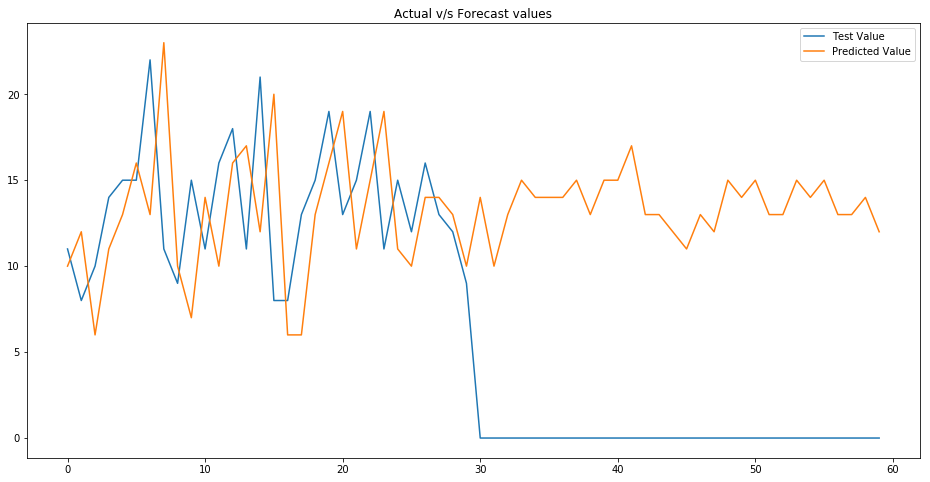

In [17]:
generic_func_predictions('queens_pred', df3, test3, dates3)

**Here, Passing Last 60 days of data for Testing, We check the Model's performance on the last 30 days data (For which we have the actual values) and the next 30 days (Predictions unknown)**

Total 30-day RMSE = 4.524010020619612


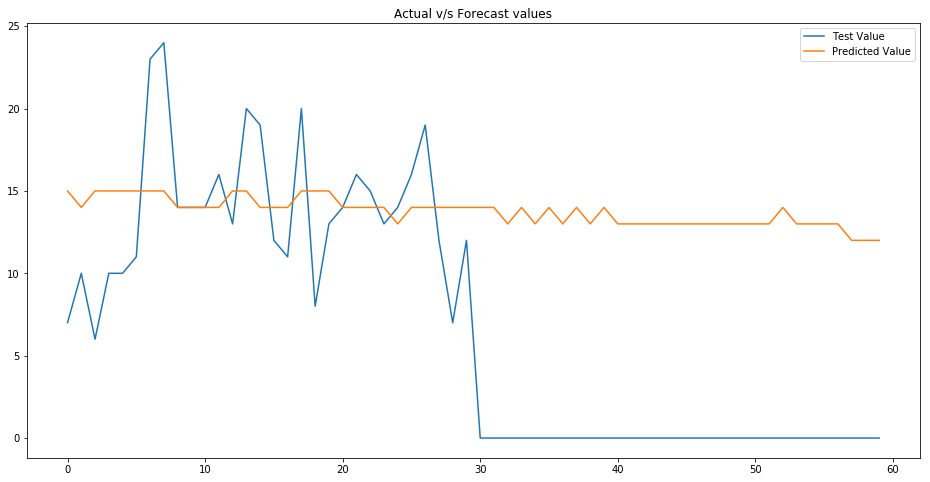

In [21]:
generic_func_predictions('manhattan_pred', df1, test1, dates1)

Total 30-day RMSE = 2.8284271247461903


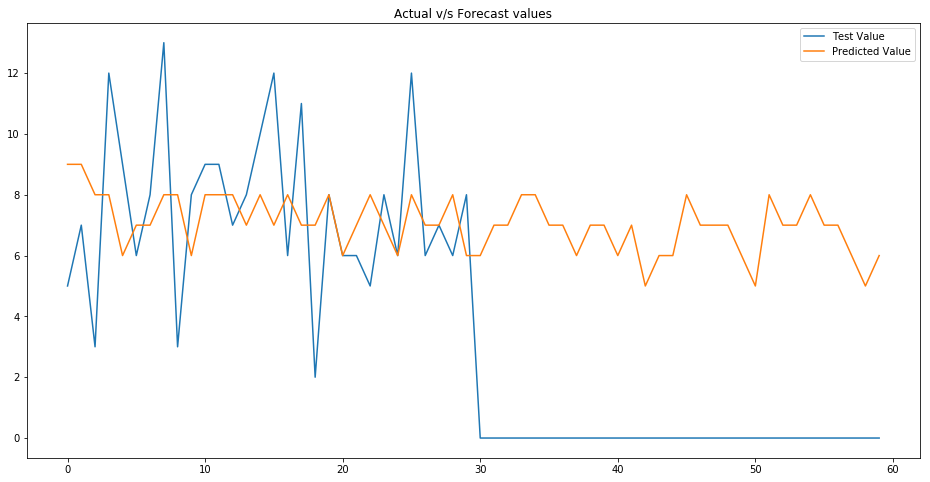

In [23]:
generic_func_predictions('bronx_pred', df4, test4, dates4)

### The Model for Manhattan and Bronx doesn't quite adapt to the extreme skews but it does get the hang of the general seasonality. 

**REFERENCES:**
- https://github.com/Pluto7-Consulting-Inc/USC-demo-class